# Estimating the Power of an Idea: A TED Talk Analysis   
   
Ali Doxey, Zach Policky, Tristan Moser

## Project Overview   
   
TED talks have been given for many years with the platform of "Ideas worth spreading". In the digital world we live in today, TED is a great platform to get your idea out there. But, how do you know if your idea will be heard or appreciated. We aim to perform a comprehensive analysis of over 2500 TED talks to figure out just what it is that makes an idea powerful.   
   
The data for this project is taken from Kaggle.com. More information on the dataset can be found here: https://www.kaggle.com/rounakbanik/ted-talks   
   
To acheive our goal of estimating the power of an idea, we will first perform data cleaning and exploration. Then, we will begin modeling to find identify what aspects of a TED talk are most useful for prediction.

## Data Cleaning   
   
Firsts thing first, we need to read in the data and clean it up so that we can do a proper analysis.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
import ast
from gensim.models import Word2Vec
pd.options.mode.chained_assignment = None

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import SGDRegressor, ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
data = pd.read_csv("/Users/tristanmoser/Files/Coding/Machine_Learning/Project/ted_main.csv")

We will look at the first talk to see what columns of data we have to work with.

In [4]:
data.head(1)

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110


At first glance we have a lot of great information to work with. Some variables of interest are:
 - Comments
 - Duration
 - Film Date / Publish Date
 - Languages
 - Ratings 
 - Tags
 - Related Talks
 - Event
 - Speaker Occupation

Some of the other variables such as description, title and speaker are very specific and can be hard to model with. For that reason they will not be considered in our analysis. For the before mentioned variables, however, we will look at how they are packaged and what feature engineering we can perform to better make use of the information they provide.

## Ratings

Whenever you view a TED talk you have the option of leaving behind a review of how you liked the talk. These ratings are a great metric of how successful a TED talk is. But in order to use it we have to see how it is packaged and what information we can gather.

In [5]:
data['ratings'][0]

"[{'id': 7, 'name': 'Funny', 'count': 19645}, {'id': 1, 'name': 'Beautiful', 'count': 4573}, {'id': 9, 'name': 'Ingenious', 'count': 6073}, {'id': 3, 'name': 'Courageous', 'count': 3253}, {'id': 11, 'name': 'Longwinded', 'count': 387}, {'id': 2, 'name': 'Confusing', 'count': 242}, {'id': 8, 'name': 'Informative', 'count': 7346}, {'id': 22, 'name': 'Fascinating', 'count': 10581}, {'id': 21, 'name': 'Unconvincing', 'count': 300}, {'id': 24, 'name': 'Persuasive', 'count': 10704}, {'id': 23, 'name': 'Jaw-dropping', 'count': 4439}, {'id': 25, 'name': 'OK', 'count': 1174}, {'id': 26, 'name': 'Obnoxious', 'count': 209}, {'id': 10, 'name': 'Inspiring', 'count': 24924}]"

The ratings column contains a list of dictionaries that is one big string object. This does not make it easy to work with as is. So, we need to create a function that will take all of the ratings and parse out the rating counts for each one.

In [6]:
#list of all ratings
ratings = ['Funny', 'Beautiful', 'Ingenious', 'Courageous', 'Longwinded', 'Confusing',
           'Informative', 'Fascinating', 'Unconvincing', 'Persuasive', 'Jaw-dropping', 'OK',
           'Obnoxious', 'Inspiring']

In [7]:
rate = []
#For this function (x) denotes the rating of interest
def parse(x):
    #Loop over all talks in dataframe
    for ll in range(len(data)):
        #First we split on the rating of interest and subsequent splits work to isolate the rating counts
        splitting = data['ratings'][ll].split(x)
        splitting2 = splitting[1].split(':')
        splitting3 = splitting2[1].split(" ")
        splitting4 = splitting3[1].split("}")
        #Isolate number of ratings
        rate.append(splitting4[0])
        series = pd.Series(rate)
        #Create column in dataframe for rating
        data[x] = series

With the function in place, we can now loop over each rating so that a column is created for each rating that a viewer can give.

In [8]:
for rating in ratings:
    parse(rating)
    rate.clear()

In [9]:
data[ratings].head()

,Funny,Beautiful,Ingenious,Courageous,Longwinded,Confusing,Informative,Fascinating,Unconvincing,Persuasive,Jaw-dropping,OK,Obnoxious,Inspiring
0,19645,4573,6073,3253,387,242,7346,10581,300,10704,4439,1174,209,24924
1,544,58,56,139,113,62,443,132,258,268,116,203,131,413
2,964,60,183,45,78,27,395,166,104,230,54,146,142,230
3,59,291,105,760,53,32,380,132,36,460,230,85,35,1070
4,1390,942,3202,318,110,72,5433,4606,67,2542,3736,248,61,2893


Beautiful! Now we have our columns with isolated ratings, but they seem pretty specific. So, we can now consolidate the ratings into the following three categories:
 - Positive
 - Moderate
 - Negative

In [10]:
#Convert ratings from string to integers so we can use mathematical operations
data[ratings] = data[ratings].astype(int)

In [11]:
#Categorize the ratings into the three broad categories
positive = ['Funny','Beautiful','Ingenious','Courageous','Inspiring','Jaw-dropping','Fascinating']
negative = ['Longwinded','Unconvincing','Obnoxious','Confusing']
moderate = ['Informative','OK','Persuasive']

In [12]:
#Create new columns that sum the ratings appropriately
data['Positive'] = data['Informative'] + data['Persuasive'] + data['Funny'] + data['Beautiful'] + data['Ingenious'] + data['Courageous'] + data['Inspiring'] + data['Jaw-dropping'] + data['Fascinating']
data['Moderate'] = data['OK']
data['Negative'] = data['Longwinded'] + data['Unconvincing'] + data['Obnoxious'] + data['Confusing']

We will take another look at the dataframe to see how our new columns look.

In [225]:
data[['Positive','Moderate','Negative']].head()

,Positive,Moderate,Negative
0,91538,1174,1138
1,2169,203,564
2,2327,146,351
3,3487,85,156
4,25062,248,310


## Related Talks

Our next column that we need to look into is "Related Talks". Again, we will look at how it is packaged and see what information we can extract.

In [34]:
data['related_talks'][0]

'[{\'id\': 865, \'hero\': \'https://pe.tedcdn.com/images/ted/172559_800x600.jpg\', \'speaker\': \'Ken Robinson\', \'title\': \'Bring on the learning revolution!\', \'duration\': 1008, \'slug\': \'sir_ken_robinson_bring_on_the_revolution\', \'viewed_count\': 7266103}, {\'id\': 1738, \'hero\': \'https://pe.tedcdn.com/images/ted/de98b161ad1434910ff4b56c89de71af04b8b873_1600x1200.jpg\', \'speaker\': \'Ken Robinson\', \'title\': "How to escape education\'s death valley", \'duration\': 1151, \'slug\': \'ken_robinson_how_to_escape_education_s_death_valley\', \'viewed_count\': 6657572}, {\'id\': 2276, \'hero\': \'https://pe.tedcdn.com/images/ted/3821f3728e0b755c7b9aea2e69cc093eca41abe1_2880x1620.jpg\', \'speaker\': \'Linda Cliatt-Wayman\', \'title\': \'How to fix a broken school? Lead fearlessly, love hard\', \'duration\': 1027, \'slug\': \'linda_cliatt_wayman_how_to_fix_a_broken_school_lead_fearlessly_love_hard\', \'viewed_count\': 1617101}, {\'id\': 892, \'hero\': \'https://pe.tedcdn.com/ima

It appears that each "Related Talks" observation contains a list of dictionaries where each dictionary contains information about a talk related to the observation talk. The information is contained in a string, so we will need to remove that before extracting any information.   
   
We are interested in using the amount of views that the related talks have. To get this feature we will create a new column that shows the mean number of views from all the related talks of one talk.

In [39]:
for ii in range(len(data)):
    #Remove string
    less = ast.literal_eval(data['related_talks'][ii])
    related_views = []
    for ll in range(len(less)):
        #Add view counts for each related talk into list
        related_views.append(less[ll]['viewed_count'])
    data['related_views'][ii] = np.mean(related_views)    

## Events

The data has a great column "Event" that lets us see where each TED talk was given. This can be a very influential piece of information as it may be likely that TED talks are more likely to be viewed when they are given at bigger conventions. There is a problem though. Who knows how many different TED events there have been? To get an idea, we look at how many different events are in our dataset.

In [41]:
data['event'].unique()

array(['TED2006', 'TED2004', 'TED2005', 'TEDGlobal 2005', 'TEDSalon 2006',
       'TED2003', 'TED2007', 'TED2002', 'TEDGlobal 2007',
       'TEDSalon 2007 Hot Science', 'Skoll World Forum 2007', 'TED2008',
       'TED1984', 'TED1990', 'DLD 2007', 'EG 2007', 'TED1998',
       'LIFT 2007', 'TED Prize Wish', 'TEDSalon 2009 Compassion',
       'Chautauqua Institution', 'Serious Play 2008', 'Taste3 2008',
       'TED2001', 'TED in the Field', 'TED2009', 'EG 2008',
       'Elizabeth G. Anderson School', 'TEDxUSC', 'TED@State',
       'TEDGlobal 2009', 'TEDxKC', 'TEDIndia 2009',
       'TEDSalon London 2009', 'Justice with Michael Sandel',
       'Business Innovation Factory', 'TEDxTC',
       'Carnegie Mellon University', 'Stanford University',
       'AORN Congress', 'University of California', 'TEDMED 2009',
       'Royal Institution', 'Bowery Poetry Club', 'TEDxSMU',
       'Harvard University', 'TEDxBoston 2009', 'TEDxBerlin', 'TED2010',
       'TEDxAmsterdam', 'World Science Festival', 

That is a lot of different events! So, we need to condense them into more broad event categories. By examination we can see that the following types of TED gatherings are common:
 - Yearly TED Conferences
 - TEDx
 - TEDGlobal
 - TEDWomen
 - TEDSalon
 - TEDNYC   
    
All other events will be categorized as "Other" as they do not appear as often.

In [42]:
#Create column with default value of "Other"
data['event_class'] = 'Other'

In [43]:
#Loop over every talk and assign event category based on name of event
for ii in range(len(data)):
    if data['event'][ii].count('TED20') >0:
        data['event_class'][ii] = 'Yearly TED Conference'
    elif data['event'][ii].count('TED19') >0:
        data['event_class'][ii] = 'Yearly TED Conference'
    elif data['event'][ii].count('TEDx') >0:
        data['event_class'][ii] = 'TEDx'
    elif data['event'][ii].count('TEDGlobal') >0:
        data['event_class'][ii] = 'TEDGlobal'
    elif data['event'][ii].count('TEDWomen') >0:
        data['event_class'][ii] = 'TEDWomen'
    if data['event'][ii].count('TEDSalon') >0:
        data['event_class'][ii] = 'TEDSalon'
    if data['event'][ii].count('TEDNYC') >0:
        data['event_class'][ii] = 'TEDNYC'
    else:
        pass

## Tags

Thusfar we have seen metrics that we can use to see how successful a talk has been, metrics for related talks, and where the talk was given. Now, we will look at what the idea is about. This is one of the most important features as it will tell us what people like to hear about in their TED talk viewing.   
   
We first will look at how the tags are packaged.

In [16]:
data['tags'].head()

0    ['children', 'creativity', 'culture', 'dance',...
1    ['alternative energy', 'cars', 'climate change...
2    ['computers', 'entertainment', 'interface desi...
3    ['MacArthur grant', 'activism', 'business', 'c...
4    ['Africa', 'Asia', 'Google', 'demo', 'economic...
Name: tags, dtype: object

In [17]:
data['tags'][9]

"['Christianity', 'God', 'culture', 'happiness', 'leadership', 'motivation', 'philanthropy', 'religion']"

Each observation contains a list of tags contained in a string. Once again, we will destring the lists so that we can work with the data. We will conveniently name the new column "Tags".

In [19]:
destring = []
for number in range(len(data)):
    #Remove string
    destring.append(ast.literal_eval(data['tags'][number]))
data['Tags'] = pd.Series(destring)

Great! Now we have information that we can use, but it is still not clear how we can. Once option could be to make a dummy variable for each unique tag. This would tell us all the tags that every observation has, but it is likely not efficient as that would be hundreds of dummy variables. Another approach is to group the tags into a smaller amount of categories. This can be very difficult as it would require going through hundreds of tags manually and assigning them a group.   
   
Luckily, there is a better, more efficient way.
   
Our approach is to use a package from Gensim known as KeyedVectors. This package is a deep learning neural network that learns the context of words and converts them to vector representations. This is extremely useful as it will allow us to see which tags are related without having to do the dirty work ourselves.

#### KeyedVectors

KeyedVectors will give us the framework we need to learn the context of our tags, but we don't have enough information with the tags alone to learn the context for each word. Thankfully, Google has taken the time to go through billions of words and learn all of their context. We will use their vector representations for our analysis.

In [50]:
from gensim.models import KeyedVectors

In [51]:
#Load Googles vectors
model = KeyedVectors.load_word2vec_format("/Users/tristanmoser/files/coding/machine_learning/Project/213Project/GoogleNews-vectors-negative300.bin.gz", binary=True)

To use KeyedVectors, we have to give it words that it has in its dictionary. Because it is a collection of single words, we cannot have any phrases or hyphenated words. We remove those tags as well as a few tags that are not contained in the vocabulary.

In [53]:
#Extract all tags from list of lists
listed = [item for sublist in destring for item in sublist]
listed = pd.Series(listed)

#Only take unique tags
lists = list(listed.unique())

#Remove phrases and hyphenated words
lists2 = [ x for x in lists if " " not in x ]
lists2 = [ x for x in lists2 if "-" not in x ]

In [ ]:
#Remove anomaly words
lists2.remove('archaeology')
lists2.remove('TEDYouth')
lists2.remove('deextinction')
lists2.remove('blockchain')
lists2.remove('TEDNYC')

#### K-Means and TSNE representation   
   
Now that our tags match up with our KeyedVectors vocabulary, we can use the vocabulary to group the tags into categories that define what content they represent. There is no easy way to do this upon simple examination so we will use the clustering technique of K-Means. K-Means uses the distance between the word vectors to determine the best clustering. With those clusters assigned we can then use TSNE to represent the high-dimensional vectors in a two-dimensional space.   
   
It is important to note that K-Means was run multiple times to get an acceptable cluster assignment.

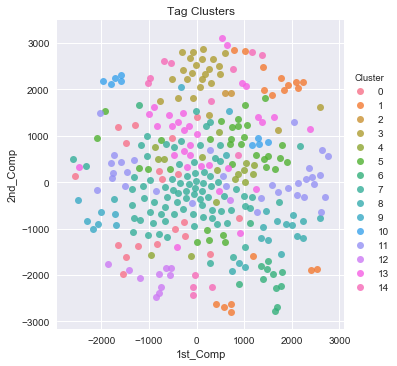

In [139]:
#List containing each word
labels = []
#List containing the vector representation of each word
tokens = []

#Populate lists 
for word in lists2:
    tokens.append(model[word])
    labels.append(word)

#TSNE model for 2D representation
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=100000, random_state=17,learning_rate=5500)
new_values = tsne_model.fit_transform(tokens)

#K-Means model to assign similar clusters
kmeans = KMeans(n_clusters=15,n_init=200)
kmeans.fit(tokens)
clusters = kmeans.predict(tokens)

#DataFrame we will use to plot
df_tsne = pd.DataFrame(new_values, columns=['1st_Comp', '2nd_Comp'])
df_tsne['Cluster'] = clusters

sns.lmplot(x='1st_Comp', y='2nd_Comp', data=df_tsne, hue='Cluster', fit_reg=False)
plt.title("Tag Clusters")

We can see from our TSNE plot that there are some unique clusters that form. The model does appear to have difficulty distinguishing where to put some similar vectors as some clusters are not very clear.   
   
With our clusters defined, we can a dictionary that converts each word to its corresponding cluster. This is not still not enough as we still cannot determine what each cluster means. As such, we look at a dataframe composed of the words and their clusters. We then look at all of the words within each cluster and assign a group title for each cluster defining what the words all have in common.   
   
With the information of what each cluster means, we can create an additional dictionary that converts the clusters to their group title. A dummy variable is then made indicating if a talk contains a tag for each of the unique tag groups.

In [140]:
#Word to Cluster
convert = {labels[word]: clusters[word] for word in range(len(labels))}

In [141]:
#Comparison DataFrame
comp = pd.DataFrame(labels)
comp['cluster'] = clusters

In [226]:
#Examine what words are in the specified cluster
comp[comp['cluster'] == 1]

,0,cluster,group
130,ants,1,animals/organisms
131,biodiversity,1,animals/organisms
133,insects,1,animals/organisms
134,animals,1,animals/organisms
135,primates,1,animals/organisms
141,fish,1,animals/organisms
143,apes,1,animals/organisms
189,bees,1,animals/organisms
191,plants,1,animals/organisms
195,bacteria,1,animals/organisms


In [211]:
#Cluster to Group Title
comp_conver = {0:'Organizing/Perceiving Information',1:'animals/organisms',2:'exploration',3:'Scientific Fields',
              4:'media/entertainment',5:'arts/creativity',6:'Epidemics',7:'Humanity/Progress',8:'Vices/Prejudices',
              9:'robots/prosthetics',10:'music',11:'philanthropy/religion',12:'Middle East',13:'Global issues',
              14:'Outer-Space',15:'NA'}

In [186]:
#Add group titles to DataFrame
comp['group'] = 'None'
for ii in range(len(comp)):
    comp['group'][ii] = comp_conver[comp['cluster'][ii]]
    
#Only take unique group titles for dummy variables
unique = comp['group'].unique()

In [212]:
for group in unique:
    #Create dummy variable for tag group
    data[group+'_tag'] = 0
    for item in range(len(data['Tags'])):
        #Loop through list of tags for each talk
        for ii in data['Tags'][item]:
            #Convert word to cluster
            try:
                clust = convert[ii]
            #If tag is not in vocabulary then we assign it 15 which voids the conversion
            except KeyError:
                clust = 15
            #Convert cluster to group title
            grouping = comp_conver[clust]
            if grouping == group:
                data[group+'_tag'][item] = 1

We can now look at our new dummy variables to examine our work.

In [214]:
data.filter(like='_tag', axis=1).head()

,Humanity/Progress_tag,arts/creativity_tag,philanthropy/religion_tag,music_tag,Global issues_tag,Scientific Fields_tag,media/entertainment_tag,Organizing/Perceiving Information_tag,Middle East_tag,Epidemics_tag,Outer-Space_tag,Vices/Prejudices_tag,exploration_tag,robots/prosthetics_tag,animals/organisms_tag
0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0
2,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0
3,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,1,1,1,1,1,0,0,0,0,0,0


## Condense Data
   
   With our data cleaning done, we look at what information we have and condense our DataFrame to only use what we care about.

In [216]:
#Current columns
data.columns

Index(['comments', 'description', 'duration', 'event', 'film_date',
       'languages', 'main_speaker', 'name', 'num_speaker', 'published_date',
       'ratings', 'related_talks', 'speaker_occupation', 'tags', 'title',
       'url', 'views', 'Funny', 'Beautiful', 'Ingenious', 'Courageous',
       'Longwinded', 'Confusing', 'Informative', 'Fascinating', 'Unconvincing',
       'Persuasive', 'Jaw-dropping', 'OK', 'Obnoxious', 'Inspiring',
       'Positive', 'Negative', 'Moderate', 'Tags', 'related_views',
       'event_class', 'Humanity/Progress_tag', 'arts/creativity_tag',
       'philanthropy/religion_tag', 'music_tag', 'Global issues_tag',
       'Scientific Fields_tag', 'media/entertainment_tag',
       'Organizing/Perceiving Information_tag', 'Middle East_tag',
       'Epidemics_tag', 'Outer-Space_tag', 'Vices/Prejudices_tag',
       'exploration_tag', 'robots/prosthetics_tag', 'animals/organisms_tag'],
      dtype='object')

In [220]:
#Drop unnecessary columns
data_final = data.drop(['description','event','film_date','num_speaker','ratings','related_talks','tags','url',
                        'Tags','main_speaker','name','Funny','Beautiful','Ingenious','Courageous','Longwinded',
                       'Confusing','Informative','Fascinating','Unconvincing','Persuasive','Jaw-dropping',
                       'OK','Obnoxious','Inspiring'],axis=1)

In [222]:
data_final.columns

Index(['comments', 'duration', 'languages', 'published_date',
       'speaker_occupation', 'title', 'views', 'Positive', 'Negative',
       'Moderate', 'related_views', 'event_class', 'Humanity/Progress_tag',
       'arts/creativity_tag', 'philanthropy/religion_tag', 'music_tag',
       'Global issues_tag', 'Scientific Fields_tag', 'media/entertainment_tag',
       'Organizing/Perceiving Information_tag', 'Middle East_tag',
       'Epidemics_tag', 'Outer-Space_tag', 'Vices/Prejudices_tag',
       'exploration_tag', 'robots/prosthetics_tag', 'animals/organisms_tag'],
      dtype='object')

In [224]:
#Save data
data_final.to_csv("/Users/tristanmoser/files/coding/machine_learning/Project/213Project/cleaned_data.csv")

## Visualization

## Modeling   
   
Now that we have a good idea of what kind of data we have and what features could be powerful in predicting a great idea, we need to create some models that can do some predicting! For our analysis we will be looking to predict three main variables:
 - **Views**: What gets people to hear an idea?
 - **Positive Ratings**: What makes people react positively to the idea?
 - **Comments**: What kinds of ideas produce discussions?
   



To get an idea as to what features most impact these variables we will build models using the following methods. For each model we use Root Mean Squared Error as the metric of evaluation:
 - Gradient Descent
 - Elastic Net Gradient Descent
 - Random Forest Regressor
 
Before we begin modeling, however, we need to split our data into training and test datasets so that we can use cross-validation to help our models learn. We will do this by placing a random 20% of our data into a cross-validation set for each target variable. 

In [134]:
data_final = pd.read_csv('/Users/tristanmoser/files/coding/machine_learning/Project/213Project/cleaned_data.csv')

In [135]:
#Define target variables
target_views = np.log(data_final.views)
target_positive = np.log(data_final.Positive)
target_comments = np.log(data_final.comments)

In [136]:
#Drop target variables and variables with no real significance
data_final = data_final.drop(['Unnamed: 0', 'speaker_occupation', 'title', 'views','Positive','Negative','Moderate','comments'], axis=1)

#Create dummy variables for our categorical variables
data_final = pd.get_dummies(data_final)

To make our lives easier, we create some functions that will perform the cross-validation for each target, the model prediction using our cross-validation, and one that will plot the coefficients for our features. Our functions code is available below for the interested listener.

In [137]:
def cross_val(df,target_param):
    #Cross-Validation set based on target variable of interest
    X_train, X_test, y_train, y_test = train_test_split(df, target_param, test_size=0.2, random_state=42)
    #Scale data
    scaler = StandardScaler()
    scaler.fit(X_train)
    scaled_train = scaler.transform(X_train)
    scaled_cv = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test, scaled_train, scaled_cv
    
def Model_Prediction(model):
    model.fit(scaled_train, y_train)
    predictions = model.predict(scaled_train)
    mse = mean_squared_error(y_train, predictions)
    cv_predictions = model.predict(scaled_cv)
    cv_mse = mean_squared_error(y_test,cv_predictions)
    print("Model Results")
    print("RMSE: {}".format(np.sqrt(mse)))
    print("CV_RMSE: {}".format(np.sqrt(cv_mse)))
    return model
    
def plot_coef(model):
    #Plot coefficients if model uses Gradient Descent
    try:
        series_coef = pd.Series(model.coef_,index = X_train.columns)
        series_coef = series_coef.sort_values()
        series_coef.plot(kind='barh',figsize=(14,9),fontsize=12)
        #plt.title('Impact of Isolated Features',fontsize=22)
        plt.ylabel('Feature',fontsize=18)
        plt.xlabel('Size of Coefficient',fontsize=18)
    except AttributeError:
        pass
    #Plot feature importance if model uses Random Forest
    try:
        series_coefs = pd.Series(model.feature_importances_,index = X_train.columns)
        series_coefs = series_coefs.sort_values()
        series_coefs.plot(kind='barh',figsize=(14,9),fontsize=12)
        #plt.title('Impact of Isolated Features',fontsize=22)
        plt.ylabel('Feature',fontsize=18)
        plt.xlabel('Level of Importance',fontsize=18)
    except AttributeError:
        pass

### Views   
   
Our first target will be views. An idea that is presented in the TED space will not amount to anything if it is never viewed. We will put our newly created functions to work to see what features best determine if an idea will be viewed or not.

Model Results
RMSE: 0.5580258177644453
CV_RMSE: 0.5481315361497205


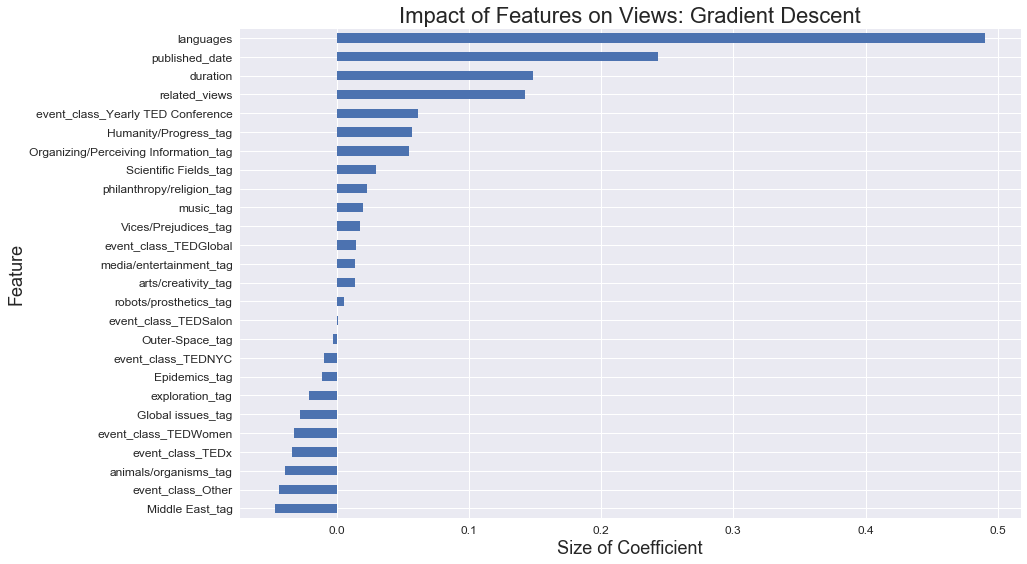

In [138]:
#Standard Gradient Descent
gradient_descent = SGDRegressor(tol=.0001, eta0=.01)

X_train, X_test, y_train, y_test, scaled_train, scaled_cv = cross_val(data_final,target_views)
Model_Prediction(gradient_descent)
plot_coef(gradient_descent)
plt.title('Impact of Features on Views: Gradient Descent',fontsize=22)

Model Results
RMSE: 0.5568639922223781
CV_RMSE: 0.5394417677937714


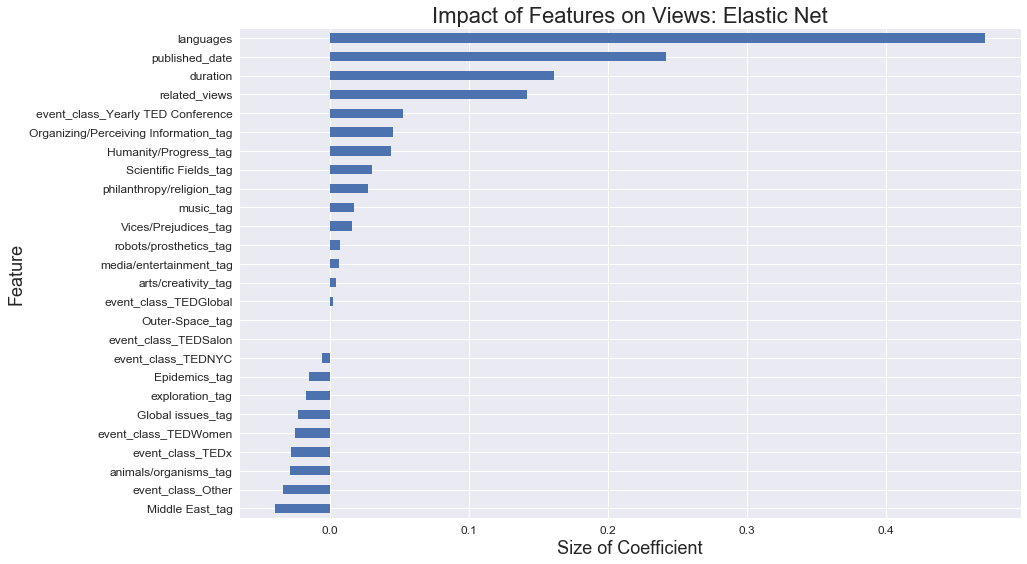

In [139]:
#Elastic Net
ENSTest = ElasticNetCV(alphas=[0.001, 0.01, 0.1, 1, 10], l1_ratio=[.01, .1, .3, .5, .7, .9, .99], max_iter=50000)

Model_Prediction(ENSTest)
plot_coef(ENSTest)
plt.title('Impact of Features on Views: Elastic Net',fontsize=22)

After some initial evaluation, it is very apparent "languages" and "published date" are very big predictors of the amount of views a talk receives. This is somewhat self-explanatory as all of those variables would definitely increase the amount of views as the talk is available to more people.   
   
It is also apparent that "related views" and "duration" are strong positive predictors of a talk being viewed.
   
To get a better idea as to what content/environment plays the biggest role in predicting the amount of views, we exclude the before mentioned variables from the analysis. Because Standard Gradient Descent and Elastic Net models produce roughly the same estimates, we will only use Elastic Net to evaluate the limited predictors. 

In [140]:
data_final = data_final.drop(['languages','published_date','duration','related_views'],axis=1)

Model Results
RMSE: 0.746305876782824
CV_RMSE: 0.7610030748747575


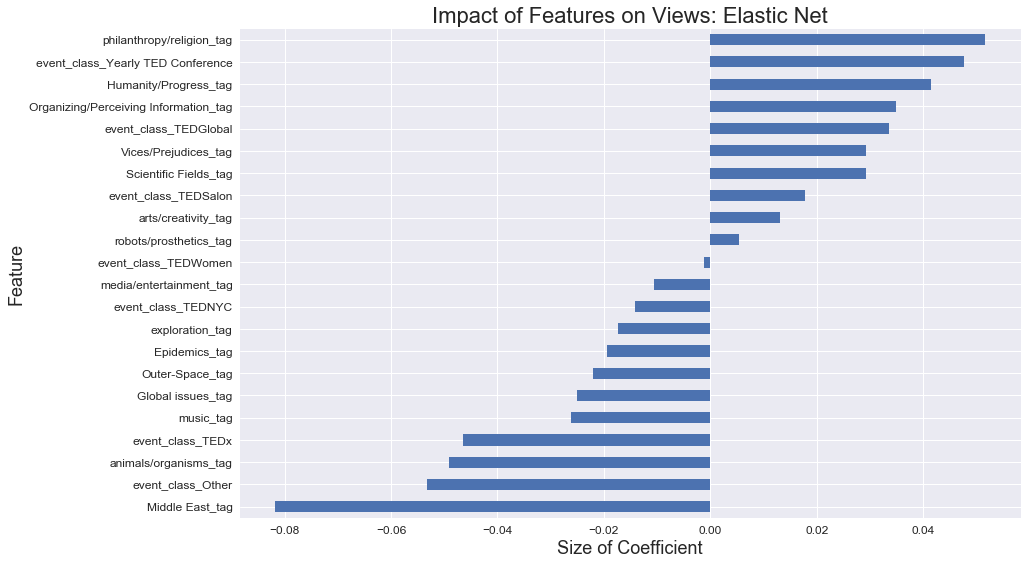

In [141]:
#Elastic Net
ENSTest = ElasticNetCV(alphas=[0.001, 0.01, 0.1, 1, 10], l1_ratio=[.01, .1, .3, .5, .7, .9, .99], max_iter=50000)

X_train, X_test, y_train, y_test, scaled_train, scaled_cv = cross_val(data_final,target_views)
Model_Prediction(ENSTest)
plot_coef(ENSTest)
plt.title('Impact of Features on Views: Elastic Net',fontsize=22)

Model Results
RMSE: 0.5717720450162314
CV_RMSE: 0.8325973394498241


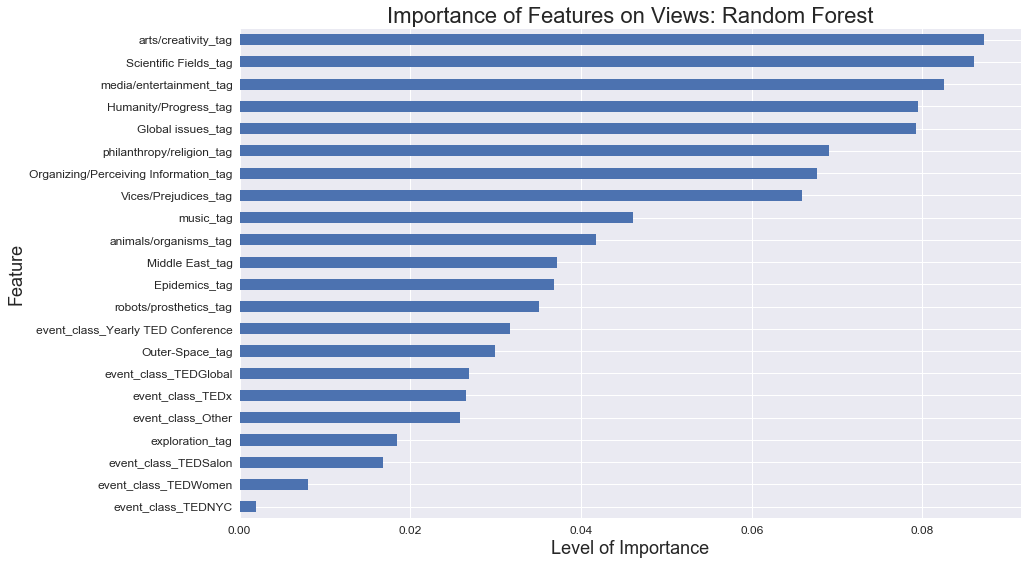

In [142]:
forest = RandomForestRegressor(max_depth = 16,max_features = 14, n_estimators=2000)

X_train, X_test, y_train, y_test, scaled_train, scaled_cv = cross_val(data_final,target_views)
Model_Prediction(forest)
plot_coef(forest)
plt.title("Importance of Features on Views: Random Forest",fontsize=22)

### Positive Ratings   
   
We have an idea of what will get an idea viewed, but what makes people respond positively to that idea. That is precisely what we aim to answer now.   
   
Because we found earlier that views and positive ratings are highly correlated, we will exclude from this analysis the variables "languages", "duration", "related views" and "published date" for the same reasons we did for views.

Model Results
RMSE: 0.8949754028554093
CV_RMSE: 0.8690079250649636


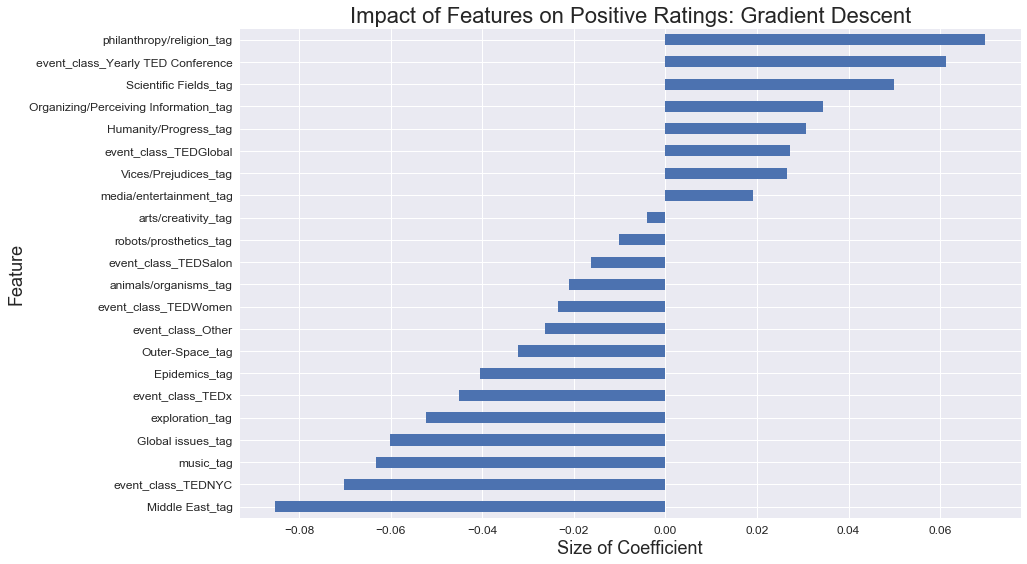

In [143]:
#Standard Gradient Descent
gradient_descentP = SGDRegressor(tol=.0001, eta0=.01)

X_train, X_test, y_train, y_test, scaled_train, scaled_cv = cross_val(data_final,target_positive)
Model_Prediction(gradient_descentP)
plot_coef(gradient_descentP)
plt.title('Impact of Features on Positive Ratings: Gradient Descent',fontsize=22)

Model Results
RMSE: 0.8941145855281487
CV_RMSE: 0.8705583399445256


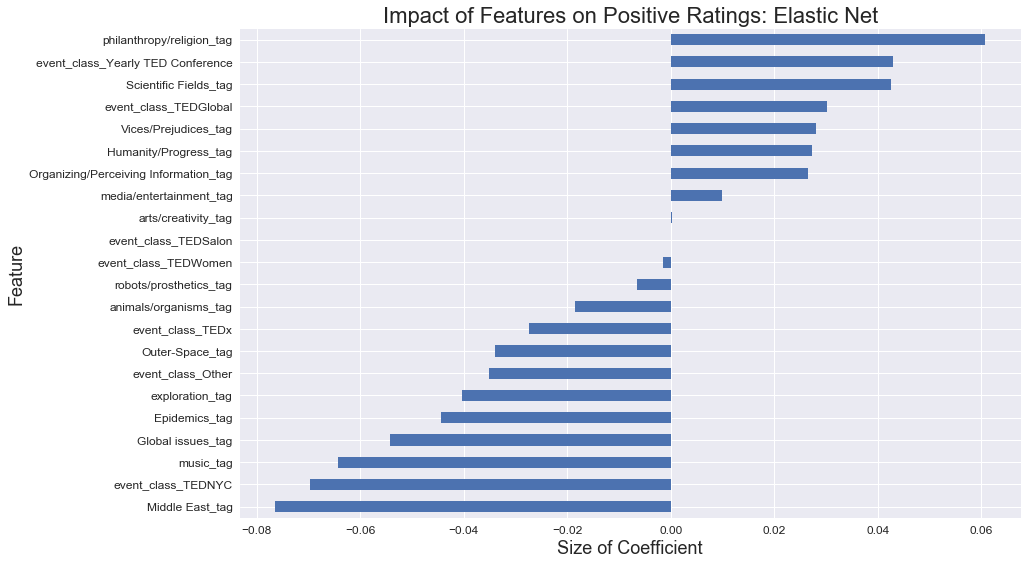

In [144]:
#Elastic Net
ENSTestP = ElasticNetCV(alphas=[0.001, 0.01, 0.1, 1, 10], l1_ratio=[.01, .1, .3, .5, .7, .9, .99], max_iter=50000)

Model_Prediction(ENSTestP)
plot_coef(ENSTestP)
plt.title('Impact of Features on Positive Ratings: Elastic Net',fontsize=22)

Model Results
RMSE: 0.6811195931675499
CV_RMSE: 0.9494300797683407


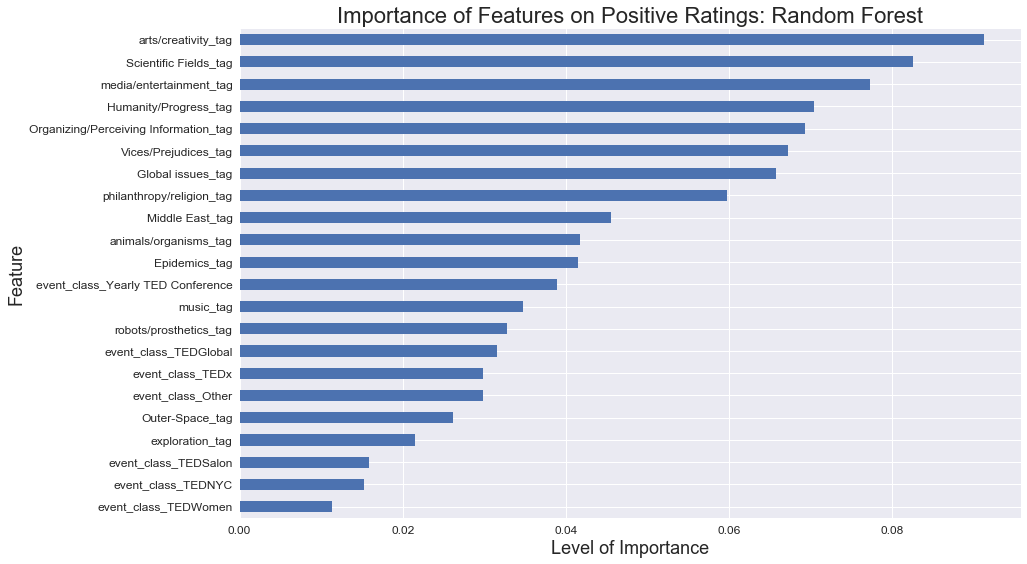

In [145]:
forestP = RandomForestRegressor(max_depth=16,max_features=12,n_estimators=2500)

Model_Prediction(forestP)
plot_coef(forestP)
plt.title("Importance of Features on Positive Ratings: Random Forest",fontsize=22)

### Comments   
   
Our next analysis will be to see what kind of material gets people talking about an idea. Everyone knows that the best way to spread your idea is to have people talk about it. Friendly arguments are, of course, preferred to ugly fights. But, publicity is publicity. So let's see what the data says.

Model Results
RMSE: 0.9295603258736825
CV_RMSE: 0.9018521020596071


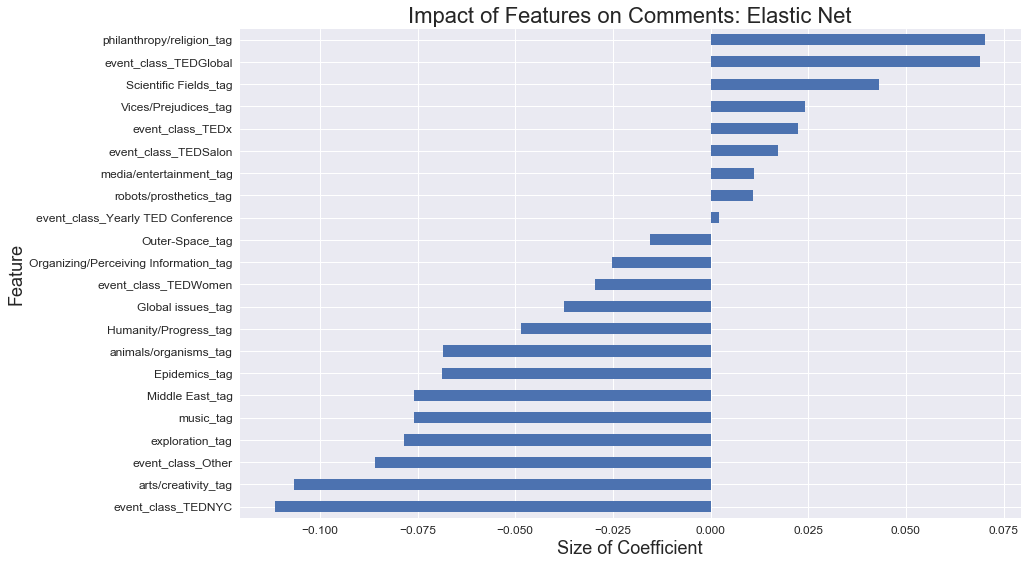

In [150]:
#Elastic Net
ENSTestC = ElasticNetCV(alphas=[0.001, 0.01, 0.1, 1, 10], l1_ratio=[.01, .1, .3, .5, .7, .9, .99], max_iter=50000)

X_train, X_test, y_train, y_test, scaled_train, scaled_cv = cross_val(data_final,target_comments)
Model_Prediction(ENSTestC)
plot_coef(ENSTestC)
plt.title('Impact of Features on Comments: Elastic Net',fontsize=22)

## Comparing Feature Importance Across Targets

In [147]:
series_coef = pd.DataFrame(ENSTestP.coef_,index = X_train.columns)
series_coef.columns=['Views']
series_coef['Positive'] = ENSTest.coef_
series_coef['Comments'] = ENSTestC.coef_
series_coef = series_coef.sort_values(by='Views')

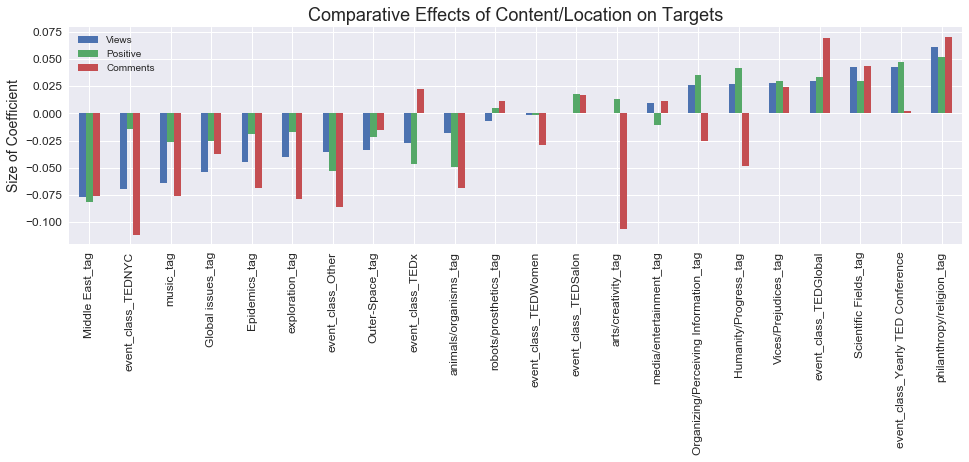

In [154]:
series_coef.plot(kind='bar',figsize=(16,4),fontsize=12)
plt.title("Comparative Effects of Content/Location on Targets",fontsize=18)
plt.ylabel("Size of Coefficient",fontsize=14)